In [1]:
import pickle
import pandas as pd 
import numpy as np 
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp
from glob import glob

In [2]:
def read_predictions_txt(file_name):
    with open(file_name) as f:
        raw_predictions = f.readlines()
    return raw_predictions

In [3]:
def get_true_and_pred(file_name):
    raw_text = read_predictions_txt(file_name)
    predictions = []
    true_values = []
    for line in raw_text:
        true_values.append(float(line.split(' ')[0]))
        predictions.append(float(line.split(' ')[2]))
    df = pd.DataFrame({'true_values' : true_values,
                                'predictions' : predictions})
    return df

In [4]:
def kolmogorov_smirnov_test(dis_1, dis_2):
    result = stats.ks_2samp(dis_1, dis_2)
    return result

In [5]:
def plot_pred_vs_true(file_name, save_filename):
    df = get_true_and_pred(file_name)
    y_true = df['true_values']
    y_pred = df['predictions']
    plt.scatter(y_true, y_pred)
    plt.ylabel('Predictions (pK)')
    plt.xlabel('True Values (pK)')
    plt.ylim(1, 13)
    plt.xlim(1, 13)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False, label='Expected relationship')
    plt.plot(y_true, np.poly1d(np.polyfit(y_true, y_pred, 1))(y_true), linestyle='-', color='red', lw=2, scalex=False, scaley=False, label='Actual relationship')
    plt.legend()
    plt.savefig(save_filename,dpi=300, bbox_inches = "tight")
    plt.show()
    return None

In [6]:
def plot_distributions(dis1, dis2, save_filename, label1 = '1', label2 = '2'):
    bin_width = 0.25
    bins = np.linspace(1, 13, 20)
    plt.hist(dis1, bins=bins, alpha = 0.7, label = label1)
    plt.hist(dis2, bins=bins, alpha = 0.7, label = label2)
    plt.legend()
    plt.xlabel('pK (pK units)')
    plt.ylabel('Frequency')
    plt.savefig(save_filename ,dpi=300, bbox_inches = "tight")
    plt.show()
    return None
    

In [7]:
def plot_distributions_of_preds_vs_true(file_name, save_filename):
    df = get_true_and_pred(file_name)
    y_true = df['true_values']
    y_pred = df['predictions']
    print(kolmogorov_smirnov_test(list(df['true_values'].values), list(df['predictions'].values)))
    plot_distributions(y_true, y_pred, label1 = 'True Values', label2 = 'Predictions', save_filename=save_filename)
    return None

In [8]:
def bootstrap_pearsonr(file_name):
    df = get_true_and_pred(file_name)
    y_true = df['true_values']
    y_pred = df['predictions']
    return bootstrap_pearsonr_calculate(y_true, y_pred)

def bootstrap_pearsonr_calculate(y_true, y_pred, n_samples=10000, seed=42):
    """Estimates a two-sided 95% confidence interval for the Pearson correlation coefficient using the bootstrap method."""
    assert len(y_true) == len(y_pred)
    indices = np.arange(len(y_true))
    coefficients = []
    r = stats.pearsonr(y_true, y_pred)[0]
    rng = np.random.default_rng(seed)
    for i in range(n_samples):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred[sample_indices]
        r_boot = stats.pearsonr(y_true_sample, y_pred_sample)[0]
        coefficients.append(r_boot)
    quantiles = np.quantile(coefficients, q=[0.025, 0.975])
    return r, quantiles

In [9]:
def bootstrap_rmse(file_name, n_samples=10000, seed=42):
    df = get_true_and_pred(file_name)
    y_true = df['true_values']
    y_pred = df['predictions']
    """Estimates a two-sided 95% confidence interval for the Pearson correlation coefficient using the bootstrap method."""
    assert len(y_true) == len(y_pred)
    indices = np.arange(len(y_true))
    coefficients = []
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    rng = np.random.default_rng(seed)
    for i in range(n_samples):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred[sample_indices]
        r_boot = mean_squared_error(y_true_sample.values, y_pred_sample.values, squared=False)
        coefficients.append(r_boot)
    quantiles = np.quantile(coefficients, q=[0.025, 0.975])
    return rmse, quantiles

In [10]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(dependent_corr(.40, .50, .10, 103, method='steiger'))
print(independent_corr(0.5 , 0.6, 103, 103, method='fisher'))


(-0.8912799047605414, 0.3749185174912557)
(1.0171097212822693, 0.3091012362386931)


In [11]:
def bootstrap_pearsonr_comparison_signficance(filename_1, filename_2, n=285, method='steiger'):
    df_1 = get_true_and_pred(filename_1)
    df_2 = get_true_and_pred(filename_2)
    xy = stats.pearsonr(df_1['true_values'], df_1['predictions'])[0]
    print(xy)
    xz = stats.pearsonr(df_2['true_values'], df_2['predictions'])[0]
    print(xz)
    yz = stats.pearsonr(df_1['predictions'], df_2['predictions'])[0]
    return dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method=method)

In [12]:
crystal_biased_filenames = [glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0],
                  glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_redocked*')[0],
                  glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_crossdocked_most*')[0],
                  glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_crossdocked_least*')[0], 
                 ]
for i in crystal_biased_filenames:
    print('--')
    for j in crystal_biased_filenames: 
        print(bootstrap_pearsonr_comparison_signficance(i, j))

--
0.7980402996492585
0.7980402996492585
(nan, nan)
0.7980402996492585
0.7366080287222194
(2.051601064675546, 0.0411319052757797)
0.7980402996492585
0.6810020656426685
(3.310399373288578, 0.0010528793831923178)
0.7980402996492585
0.6484872653378535
(3.92384798318244, 0.00010955100213450031)
--
0.7366080287222194
0.7980402996492585
(-2.051601064675546, 0.0411319052757797)
0.7366080287222194
0.7366080287222194
(nan, nan)
0.7366080287222194
0.6810020656426685
(2.22283874513349, 0.027019569478895722)
0.7366080287222194
0.6484872653378535
(3.149718250497527, 0.0018099028343288026)
--
0.6810020656426685
0.7980402996492585
(-3.310399373288578, 0.0010528793831923178)
0.6810020656426685
0.7366080287222194
(-2.22283874513349, 0.027019569478895722)
0.6810020656426685
0.6810020656426685
(0.0, 1.0)
0.6810020656426685
0.6484872653378535
(1.1235204711752491, 0.26217204842333186)
--
0.6484872653378535
0.7980402996492585
(-3.9238479831824407, 0.00010955100213450031)
0.6484872653378535
0.736608028722219

/tmp/ipykernel_2848570/132893536.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
/tmp/ipykernel_2848570/132893536.py:36: RuntimeWarning: invalid value encountered in double_scalars
  t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
/tmp/ipykernel_2848570/132893536.py:36: RuntimeWarning: invalid value encountered in sqrt
  t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))


In [13]:
docked_biased_filenames = [glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol-*')[0],
                  glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_redocked*')[0],
                  glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_crossdocked_most*')[0],
                  glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_crossdocked_least*')[0], 
                 ]
for i in docked_biased_filenames:
    print('---')
    for j in docked_biased_filenames: 
        print(bootstrap_pearsonr_comparison_signficance(i, j))

---
0.7706686954914094
0.7706686954914094
(nan, nan)
0.7706686954914094
0.7526701446432225
(0.5983628007163049, 0.5500781646575499)
0.7706686954914094
0.7430246428168512
(0.8569690627948459, 0.39218964376060894)
0.7706686954914094
0.6943191180452991
(2.0501385665776373, 0.04127540268385266)
---
0.7526701446432225
0.7706686954914094
(-0.5983628007163049, 0.5500781646575499)
0.7526701446432225
0.7526701446432225
(nan, nan)
0.7526701446432225
0.7430246428168512
(0.290388222461001, 0.771732681314619)
0.7526701446432225
0.6943191180452991
(1.500156861379863, 0.1346924990510141)
---
0.7430246428168512
0.7706686954914094
(-0.8569690627948459, 0.39218964376060894)
0.7430246428168512
0.7526701446432225
(-0.290388222461001, 0.771732681314619)
0.7430246428168512
0.7430246428168512
(0.0, 1.0)
0.7430246428168512
0.6943191180452991
(2.5664001296381387, 0.010792552531253996)
---
0.6943191180452991
0.7706686954914094
(-2.0501385665776373, 0.04127540268385266)
0.6943191180452991
0.7526701446432225
(-1.

/tmp/ipykernel_2848570/132893536.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
/tmp/ipykernel_2848570/132893536.py:36: RuntimeWarning: invalid value encountered in double_scalars
  t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))


In [14]:
for i,j in zip(docked_biased_filenames, crystal_biased_filenames):
    print(bootstrap_pearsonr_comparison_signficance(i, j))

0.7706686954914094
0.7980402996492585
(-1.67059032669554, 0.09591205807463998)
0.7526701446432225
0.7366080287222194
(0.47085089738321534, 0.6381112176498438)
0.7430246428168512
0.6810020656426685
(3.077631004901332, 0.0022918393405375603)
0.6943191180452991
0.6484872653378535
(2.4087375620892244, 0.01664921166862654)


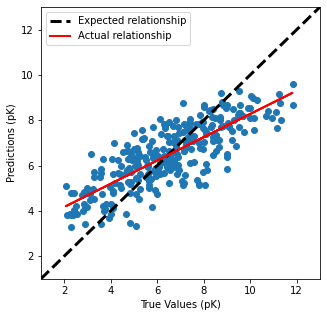

(0.7980402996492585, array([0.75429892, 0.8352957 ]))


In [15]:
plt.rcParams["figure.figsize"] = (5,5)
plot_pred_vs_true(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0], 'rotation_1_figs/crystal_distribution_scatter.png')
print(bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0]))


KstestResult(statistic=0.13333333333333333, pvalue=0.012529347923235701)


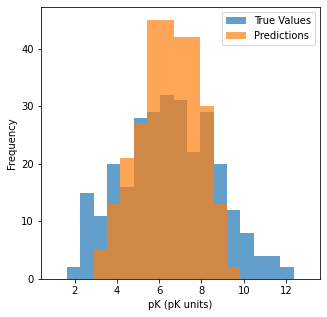

In [16]:
plot_distributions_of_preds_vs_true(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0], 'rotation_1_figs/crystal_distribution_histogram.png')

In [17]:
plot_distributions_of_preds_vs_true(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol-*')[0])

TypeError: plot_distributions_of_preds_vs_true() missing 1 required positional argument: 'save_filename'

In [18]:
plot_pred_vs_true(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol-*')[0])
print(bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol-*')[0]))

TypeError: plot_pred_vs_true() missing 1 required positional argument: 'save_filename'

In [19]:
# CRYSTAL BIASED

In [20]:
crystal_biased = [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol_crossdocked_least*')[0]), 
                 ]
crystal_unbiased = [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol_crossdocked_least*')[0]),
                   ]
crystal_unbiased_size_control = [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30_size_control/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30_size_control/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30_size_control/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30_size_control/predictions_casf_2016_pymol_crossdocked_least*')[0]),
                   ]
docked_biased = [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol_crossdocked_least*')[0]), 
                ]
docked_unbiased = [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30/predictions_casf_2016_pymol_crossdocked_least*')[0]),
                  ]
docked_unbiased_size_control = [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30_size_control/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30_size_control/predictions_casf_2016_pymol_redocked*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30_size_control/predictions_casf_2016_pymol_crossdocked_most*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30_size_control/predictions_casf_2016_pymol_crossdocked_least*')[0]),
                  ]

In [35]:
crystal_unbiased

[(0.6994857432250254, array([0.63176811, 0.75799509])),
 (0.6760513860699244, array([0.60576699, 0.73558591])),
 (0.7034729888866442, array([0.64689223, 0.75311205])),
 (0.624769454115458, array([0.55530701, 0.68414201]))]

In [21]:
import matplotlib.pyplot as plt

In [22]:
plt.rcParams["figure.figsize"] = (3,4)

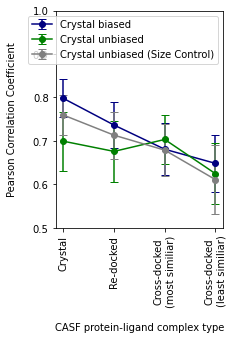

In [23]:
labels= ['Crystal', 'Re-docked', 'Cross-docked\n(most similiar)', 'Cross-docked\n(least similiar)']

plt.errorbar(labels, [i[0] for i in crystal_biased], yerr = [i[0]-i[1][0] for i in crystal_biased], fmt='-o', capsize = 4, label = 'Crystal biased', color='navy')
plt.errorbar(labels, [i[0] for i in crystal_unbiased], yerr = [i[0]-i[1][0] for i in crystal_unbiased],fmt='-o', capsize = 4, label = 'Crystal unbiased', color='green')
plt.errorbar(labels, [i[0] for i in crystal_unbiased_size_control], yerr = [i[0]-i[1][0] for i in crystal_unbiased_size_control],fmt='-o', capsize = 4, label = 'Crystal unbiased (Size Control)', color='grey')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\nCASF protein-ligand complex type')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title('Comparision of training on biased and unbiased Crystal PDBBind \non different CASF performance \n')
plt.legend()
plt.savefig('rotation_1_figs/crystal_comparison_bias_vs_debias.png',dpi=300, bbox_inches = "tight")
plt.show()

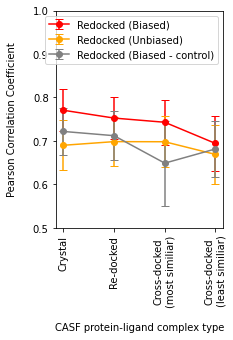

In [24]:
labels= ['Crystal', 'Re-docked', 'Cross-docked\n(most similiar)', 'Cross-docked\n(least similiar)']

plt.errorbar(labels, [i[0] for i in docked_biased], yerr = [i[0]-i[1][0] for i in docked_biased], fmt='-o', capsize = 4, label = 'Redocked (Biased)', color='red')
plt.errorbar(labels, [i[0] for i in docked_unbiased], yerr = [i[0]-i[1][0] for i in docked_unbiased],fmt='-o', capsize = 4, label = 'Redocked (Unbiased)', color='orange')
plt.errorbar(labels, [i[0] for i in docked_unbiased_size_control], yerr = [i[0]-i[1][0] for i in docked_unbiased_size_control],fmt='-o', capsize = 4, label = 'Redocked (Biased - control)', color='grey')

plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\nCASF protein-ligand complex type')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title('Comparision of training on biased and unbiased Redocked PDBBind \non different CASF performance \n')
plt.legend()
plt.savefig('rotation_1_figs/redocked_comparison_bias_vs_debias.png',dpi=300, bbox_inches = "tight")
plt.show()

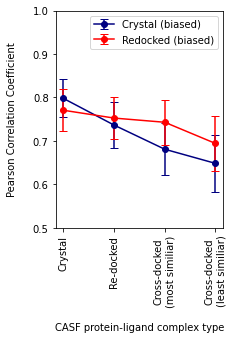

In [25]:
labels= ['Crystal', 'Re-docked', 'Cross-docked\n(most similiar)', 'Cross-docked\n(least similiar)']

# plt.errorbar(labels, [i[0] for i in crystal_biased], yerr = [i[0]-i[1][0] for i in crystal_biased], fmt='-o', capsize = 4, label = 'Crystal biased', color='navy')
plt.errorbar(labels, [i[0] for i in crystal_biased], yerr = [i[0]-i[1][0] for i in crystal_biased], fmt='-o', capsize = 4, label = 'Crystal (biased)', color='navy')
plt.errorbar(labels, [i[0] for i in docked_biased], yerr = [i[0]-i[1][0] for i in docked_biased],fmt='-o', capsize = 4, label = 'Redocked (biased)', color='red')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\nCASF protein-ligand complex type')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title('Comparision of training on biased Redocked and Crystal PDBBind \non different CASF performance \n')
plt.savefig('rotation_1_figs/comparison_different_casf_biased.png',dpi=300, bbox_inches = "tight")
plt.legend()
plt.show()

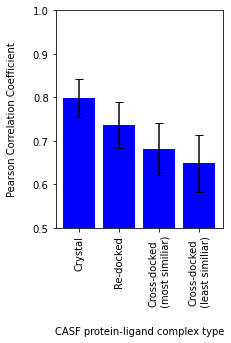

In [26]:
labels= ['Crystal', 'Re-docked', 'Cross-docked\n (most similiar)', 'Cross-docked\n (least similiar)']

plt.bar(labels, [i[0] for i in crystal_biased], yerr = [i[0]-i[1][0] for i in crystal_biased], capsize = 4, label = 'Crystal biased', color='blue')
# plt.errorbar(labels, [i[0] for i in docked_biased], yerr = [i[0]-i[1][0] for i in docked_biased],fmt='-o', capsize = 4, label = 'Redocked biased', color='red')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\nCASF protein-ligand complex type')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title("Scoring Function Trained on Crystal PDBBind 2020 General's\n performance on different CASF test sets \n")
plt.savefig('rotation_1_figs/crystal_different_casf_biased.png',dpi=300, bbox_inches = "tight")
plt.show()

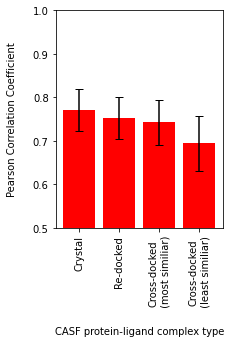

In [27]:
labels= ['Crystal', 'Re-docked', 'Cross-docked\n (most similiar)', 'Cross-docked\n (least similiar)']

# plt.bar(labels, [i[0] for i in crystal_biased], yerr = [i[0]-i[1][0] for i in crystal_biased], capsize = 4, label = 'Crystal biased', color='blue')
plt.bar(labels, [i[0] for i in docked_biased], yerr = [i[0]-i[1][0] for i in docked_biased], capsize = 4, label = 'Redocked biased', color='red')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\nCASF protein-ligand complex type')
plt.ylabel('Pearson Correlation Coefficient\n')
plt.savefig('rotation_1_figs/redocked_different_casf_biased.png',dpi=300, bbox_inches = "tight")
# plt.title("Scoring Function Trained on Re-docked PDBBind 2020 General's\n performance on different CASF test sets \n")
plt.show()

In [28]:
crystal_seq = [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_seq_100/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_seq_90/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_seq_30/predictions_casf_2016_pymol-*')[0]), 
                 ]
crystal_tan =  [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_tan_100/predictions_casf_2016_pymol-*')[0]),
#                 (0.75, (0.60, 0.80)),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_tan_90/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_tan_30/predictions_casf_2016_pymol-*')[0]), 
                 ]
crystal_both = [bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_100/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_90/predictions_casf_2016_pymol-*')[0]),
#                                 (0.75, (0.60, 0.80)),
                  bootstrap_pearsonr(glob('../crystal_regression/PointBAP/crystal_regression_both_30/predictions_casf_2016_pymol-*')[0]), 
                 ]
docked_seq = [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_seq_100/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_seq_90/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_seq_30/predictions_casf_2016_pymol-*')[0]), 
#                               (0.75, (0.60, 0.80)),
                 ]
docked_tan =  [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_tan_100/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_tan_90/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_tan_30/predictions_casf_2016_pymol-*')[0]), 
                 ]
docked_both = [bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_100/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_90/predictions_casf_2016_pymol-*')[0]),
                  bootstrap_pearsonr(glob('../docked_regression/PointBAP/docked_regression_both_30/predictions_casf_2016_pymol-*')[0]), 
                 ]

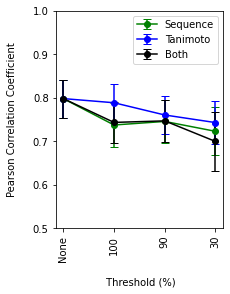

In [29]:
labels= ['None', '100', '90', '30']

plt.errorbar(labels, [i[0] for i in crystal_seq], yerr = [i[0]-i[1][0] for i in crystal_seq], fmt='-o', capsize = 4, label = 'Sequence', color='green')
plt.errorbar(labels, [i[0] for i in crystal_tan], yerr = [i[0]-i[1][0] for i in crystal_tan], fmt='-o', capsize = 4, label = 'Tanimoto', color='blue')
plt.errorbar(labels, [i[0] for i in crystal_both], yerr = [i[0]-i[1][0] for i in crystal_both], fmt='-o', capsize = 4, label = 'Both', color='black')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\n Threshold (%)')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title('Comparision of training on biased Redocked and Crystal PDBBind \non different CASF performance \n')
plt.legend()
plt.savefig('rotation_1_figs/debiasing_crystal.png',dpi=300, bbox_inches = "tight")
plt.show()

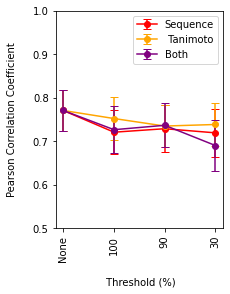

In [30]:
labels= ['None', '100', '90', '30']

plt.errorbar(labels, [i[0] for i in docked_seq], yerr = [i[0]-i[1][0] for i in docked_seq], fmt='-o', capsize = 4, label = 'Sequence', color='red')
plt.errorbar(labels, [i[0] for i in docked_tan], yerr = [i[0]-i[1][0] for i in docked_tan], fmt='-o', capsize = 4, label = ' Tanimoto', color='orange')
plt.errorbar(labels, [i[0] for i in docked_both], yerr = [i[0]-i[1][0] for i in docked_both], fmt='-o', capsize = 4, label = 'Both', color='purple')
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.xlabel('\n Threshold (%)')
plt.ylabel('Pearson Correlation Coefficient\n')
# plt.title('Comparision of training on biased Redocked and Crystal PDBBind \non different CASF performance \n')
plt.legend()
plt.savefig('rotation_1_figs/debiasing_redocked.png',dpi=300, bbox_inches = "tight")
plt.show()